LSTM is an RNN that can capture the pattern in sequential data. The benefit is that it can learn and remember for long sequences. In keras this is referred to as setting the stateful argument as true in the lstm layer 
Lstm includes three important gates: input gate, forget gate and the output gate. The interactive operation among these three gates makes LSTM have the sufficient ability to solve the problem of long-term dependencies
which general RNNs cannot learn. "The learning speed of the previous hidden layers is slower than the deeper
hidden layers. This phenomenon may even lead to a decrease of accuracy rate as hidden layers
increase [25]. However, the smart design of the memory cell in LSTM can effectively solve the problem
of gradient vanishing in backpropagation and can learn the input sequence with longer time steps.
Hence, LSTM is commonly used for solving applications related to time serial issues. "

- LSTMs are a type of recurrent network, and as such are designed to take sequence data as input, unlike other models where lag observations must be presented as input features.
- LSTMs directly support multiple parallel input sequences for multivariate inputs, unlike other models where multivariate inputs are presented in a flat structure.
- Like other neural networks, LSTMs are able to map input data directly to an output vector that may represent multiple output time steps.

- A popular approach has been to combine CNNs with LSTMs, where the CNN is as an encoder to learn features from sub-sequences of input data which are provided as time steps to an LSTM. This architecture is called a CNN-LSTM.
- A power variation on the CNN LSTM architecture is the ConvLSTM that uses the convolutional reading of input subsequences directly within an LSTM’s units. This approach has proven very effective for time series classification and can be adapted for use in multi-step time series forecasting.

In [69]:
import numpy as np
import pandas as pd
import pickle 
import sklearn 
import matplotlib.pyplot as plt 

In [70]:
with open('../data/train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)

In [71]:
with open('../data/test_data.pickle', 'rb') as f:
    test_data = pickle.load(f)

In [72]:
with open('../data/scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)

In [113]:
#def evaluate_forecasts(actual, predicted):
train_data.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


In [99]:
test_data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2014-07-02 12:00:00,0.056338,0.897059,0.704918,0.218182,0.333333,0.005349,0.0,0.0
2014-07-02 13:00:00,0.064386,0.897059,0.721311,0.218182,1.000000,0.000752,0.0,0.0
2014-07-02 14:00:00,0.066398,0.897059,0.721311,0.200000,1.000000,0.002273,0.0,0.0
2014-07-02 15:00:00,0.072435,0.897059,0.737705,0.200000,1.000000,0.003794,0.0,0.0
2014-07-02 16:00:00,0.078471,0.897059,0.737705,0.200000,1.000000,0.005315,0.0,0.0


## Moving Window NOT CV

The LSTM takes sequences of inputs. The pollution values can either be included (as lagged values) in the input or left out. 

In [190]:
def generate_sequence(df,N, window_size):
    '''Model expects the target labels to have two 
        dimensions with shape (batch_size,output_size). 
        - batch_size is the number of samples in each sequence
        - output_size is the number of target values per sample'''
        
    #We generate sequences of size 24
    X_sequences = [df.iloc[i:i+window_size].values for i in range(N - window_size)]
    #And for each sequence evaluate agains the pollution value following each sequence
    Y_values = [df.iloc[i+window_size]['pollution'] for i in range(N - window_size)]


    return np.array(X_sequences), np.array(Y_values).reshape(-1,1)



Limit of sequence size is related to vanishing gradient problem. This can limit how well an LSTM can learn dependencies far back in the sequence, especially if the model isn’t deep enough to capture long-term patterns.

In [191]:
window_size = 10
N= len(train_data)
X_train, y_train = generate_sequence(train_data,N, window_size)
print(X_train.shape, y_train.shape)

M=len(test_data)
X_test, y_test = generate_sequence(test_data,M,window_size)
print(X_test.shape,y_test.shape)




(39410, 10, 8) (39410, 1)
(4370, 10, 8) (4370, 1)


Note: we reshape input to be 3D [samples, timesteps, features]

In [192]:
X_train.shape[1]

10

In [193]:
X_train.dtype

dtype('float32')

In [194]:
X_train.shape[2]

8

In [195]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

In [196]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D


history.predict(X_test): This generates predictions for X_test, resulting in a 2D array with shape (n, 1), where n is the number of test samples.
.flatten(): Converts this (n, 1) array to a 1D array with shape (n,), making it easier to work with 

# Standard LSTM

The model mininmizes mse and the mse loss is used for backpropoagtion to update the model's weights. RMSE is the evaluation metric.

In [186]:

STD_LSTM = Sequential()
STD_LSTM.add(Input(shape =(n_steps, n_features)))
STD_LSTM.add(LSTM(50))
STD_LSTM.add(Dense(1))
STD_LSTM.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metrics = [RootMeanSquaredError()])


STD_LSTM.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,851 (46.29 KB)

 Trainable params: 11,851 (46.29 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:


with tf.device('/CPU:0'):
    STD_LSTM.fit(X_train,y_train, epochs= 20,  validation_split=0.1, batch_size=64,shuffle=False)

train_loss, train_rmse =  STD_LSTM.evaluate(X_train,y_train, verbose=0)
print(train_rmse)
test_loss,test_rmse = STD_LSTM.evaluate( X_test,y_test,verbose=0)
print(test_rmse)



Epoch 1/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 8.5048e-04 - root_mean_squared_error: 0.0289 - val_loss: 6.2057e-04 - val_root_mean_squared_error: 0.0249
Epoch 2/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.5333e-04 - root_mean_squared_error: 0.0290 - val_loss: 6.3483e-04 - val_root_mean_squared_error: 0.0252
Epoch 3/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.5205e-04 - root_mean_squared_error: 0.0290 - val_loss: 6.4611e-04 - val_root_mean_squared_error: 0.0254
Epoch 4/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8.4955e-04 - root_mean_squared_error: 0.0289 - val_loss: 6.5458e-04 - val_root_mean_squared_error: 0.0256
Epoch 5/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8.4630e-04 - root_mean_squared_error: 0.0289 - val_loss: 6.6053e-04 - val_root_mean_squared_error: 0.0257
Epoch 6/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8.4269e-04 - root_mean_squared_error: 0.0288 - val_loss: 6.6434e-04 - val_root_mean_squared_error: 0.0258
Epo

In [84]:
train_loss, train_rmse =  STD_LSTM.evaluate(X_train,y_train, verbose=0)
print(train_rmse)
test_loss,test_rmse = STD_LSTM.evaluate( X_test,y_test,verbose=0)
print(test_rmse)

0.027436107397079468
0.024431224912405014


## Stacked LSTM

Every LSTM layer should be accompanied by a Dropout layer. This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons. 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.

After trialling different types of LSTM models with different activation functions and parameters, we decided the Stacked LSTM with tanh function was best in terms of performance and retaining a strong accuracy.

In [197]:

STCK_LSTM = Sequential()
STCK_LSTM.add(Input(shape =(n_steps, n_features)))
STCK_LSTM.add(LSTM(32,return_sequences=True))
STCK_LSTM.add(Dropout(0.2)) #Prevent overfitting
STCK_LSTM.add(LSTM(16, return_sequences=False))
STCK_LSTM.add(Dense(n_outputs, activation='tanh')) 
STCK_LSTM.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metrics = [RootMeanSquaredError()])

STCK_LSTM.summary()



Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 10, 32)         │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401 (32.82 KB)

 Trainable params: 8,401 (32.82 KB)

 Non-trainable params: 0 (0.00 B)

## Early Stopping

In [198]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [199]:
with tf.device('/CPU:0'):
    history = STCK_LSTM.fit(X_train, y_train, epochs=100, validation_split=0.1,  callbacks=[early_stopping], batch_size=64,shuffle=False)

Epoch 1/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0063 - root_mean_squared_error: 0.0774 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554
Epoch 2/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 3/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 4/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 5/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 7.4839e-04 - val_root_mean_squared_error: 0.0274
Epoch 6/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 7.7582e-04 - val_root_mean_squared_error: 0.0279
Epoch 7/100
555/555 ━━━━━━━━━━━━━━━━━━

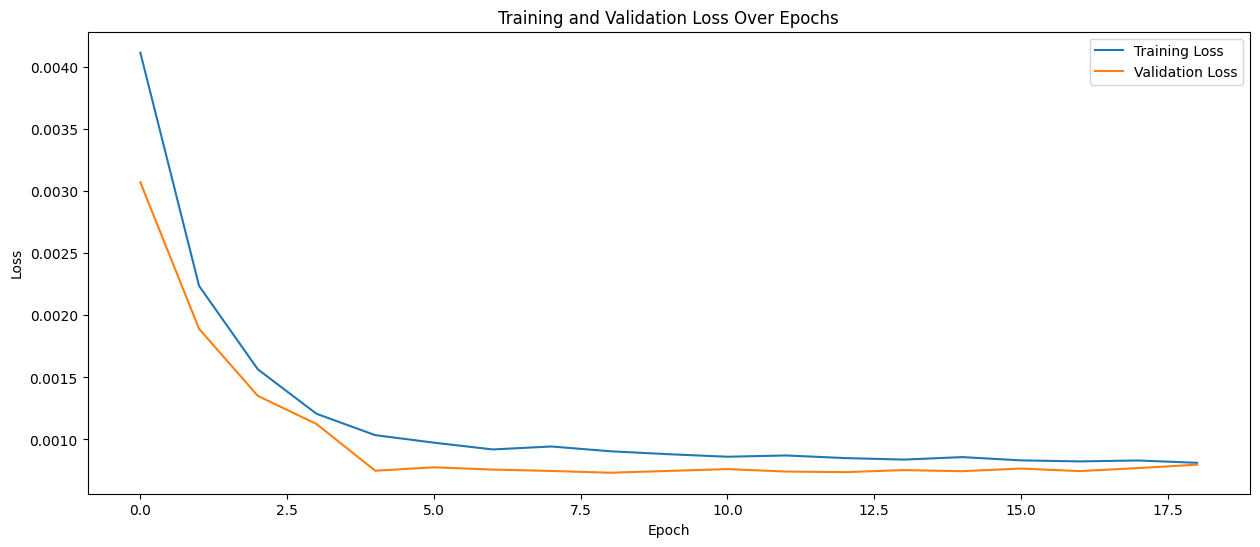

In [200]:
# Plotting the Training and Validation Loss Over Epochs
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')      # Plotting training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plotting validation loss

# Adding labels to the axes
plt.xlabel('Epoch')    # Label for the x-axis
plt.ylabel('Loss')      # Label for the y-axis

# Adding a legend to distinguish between training and validation loss
plt.legend()

# Adding a title to the plot
plt.title('Training and Validation Loss Over Epochs')

# Displaying the plot
plt.show()

## Model epoch and rmse performance 

In [110]:
epochs=[]
train_rmse=[]
test_rmse=[]
delta_epochs=5
eon=0
for i in range(0,10) : 
        print("epoch : " + str(eon))
        STCK_LSTM.fit(X_train, y_train, epochs=delta_epochs, batch_size=64,validation_split=0.1)
        train_scores = STCK_LSTM.evaluate(X_train, y_train)   
        tests_scores = STCK_LSTM.evaluate(X_test, y_test)
        eon+=delta_epochs
        epochs.append(eon)
        train_rmse.append(train_scores[1]) #RMSE
        test_rmse.append(tests_scores[1])

epoch : 0
Epoch 1/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 8.2933e-04 - root_mean_squared_error: 0.0288 - val_loss: 5.7869e-04 - val_root_mean_squared_error: 0.0241
Epoch 2/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 7.2935e-04 - root_mean_squared_error: 0.0270 - val_loss: 5.9951e-04 - val_root_mean_squared_error: 0.0245
Epoch 3/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 7.2236e-04 - root_mean_squared_error: 0.0269 - val_loss: 6.1508e-04 - val_root_mean_squared_error: 0.0248
Epoch 4/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 7.3391e-04 - root_mean_squared_error: 0.0271 - val_loss: 5.7250e-04 - val_root_mean_squared_error: 0.0239
Epoch 5/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 7.5255e-04 - root_mean_squared_error: 0.0274 - val_loss: 5.8324e-04 - val_root_mean_squared_error: 0.0242
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.4321e-04 - root_mean_squared_error: 0.0272
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7498e-04 - ro

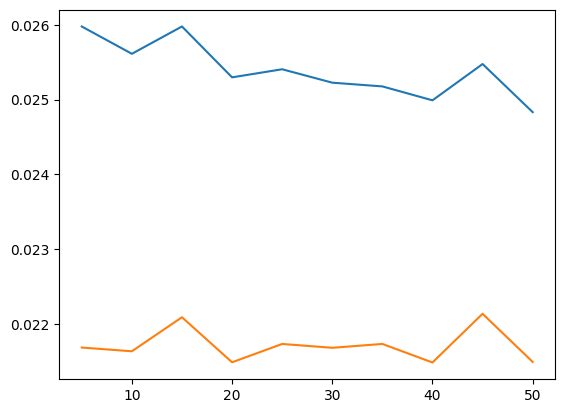

In [111]:
results=[epochs,
        train_rmse,
        test_rmse]
plt.plot(epochs,train_rmse,label='training RMSE')
plt.plot(epochs,test_rmse,label='test RMSE')
plt.show()

# NEED TO EVALUATE MODEL EACH TIME BEFORE SEEING HOW IT PERFORMS ON TEST 

From early stopping we have determined a good epoch value is less than 20 so let's see have a closer look on how accuracy is affected. 

The model is trained incrementally, but it retains the weights from previous iterations. This means that even though scaledtormodel.fit runs for only 5 epochs in each loop, the total effective training time for the model is the cumulative epoch count (eon).


## Evaluation: 
By this we see the optimal epoch value is between 15 and 20 and we continue with an epoch value of 17

- Try without final dense(activation='relu') layer 
- try early stopping 
- try different batch size but might cause overfitting 
- first make some nice graphs 
- then try different techniques entirely 


## DO A BATCH SIZE TEST ERROR PLOT TO DECIDCDE ON A BATCH SIZE 

In [63]:
X_train.shape

(43452, 12, 8)

[samples, timesteps, features]

In [114]:
with tf.device('/CPU:0'):
    STCK_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=64,shuffle=False)

Epoch 1/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 7.5106e-04 - root_mean_squared_error: 0.0273 - val_loss: 5.5612e-04 - val_root_mean_squared_error: 0.0236
Epoch 2/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 7.4527e-04 - root_mean_squared_error: 0.0272 - val_loss: 5.5703e-04 - val_root_mean_squared_error: 0.0236
Epoch 3/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 7.3422e-04 - root_mean_squared_error: 0.0270 - val_loss: 5.7432e-04 - val_root_mean_squared_error: 0.0240
Epoch 4/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 7.4543e-04 - root_mean_squared_error: 0.0272 - val_loss: 5.7537e-04 - val_root_mean_squared_error: 0.0240
Epoch 5/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 7.3200e-04 - root_mean_squared_error: 0.0270 - val_loss: 5.9860e-04 - val_root_mean_squared_error: 0.0245
Epoch 6/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 7.2820e-04 - root_mean_squared_error: 0.0269 - val_loss: 6.0838e-04 - val_root_mean_squared_error: 0.0247
Epo

In [116]:
train_metrics = STCK_LSTM.evaluate(X_train,y_train)
print(f"Train RMSE: {train_metrics[1]:.5f}")


test_metrics = STCK_LSTM.evaluate(X_test,y_test)
print(f"Test RMSE: {test_metrics[1]:.5f}")

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.4670e-04 - root_mean_squared_error: 0.0273
Train RMSE: 0.02632
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7638e-04 - root_mean_squared_error: 0.0218
Test RMSE: 0.02423


In [117]:
test_predictions = STCK_LSTM.predict(X_test).flatten()
actual_predictions = y_test.flatten()
test_predictions.shape, actual_predictions.shape

test_results = pd.DataFrame(data={
        'Model Predictions': test_predictions,
        'Actual':actual_predictions})
test_results.head()

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


,Model Predictions,Actual
0,0.133343,0.110664
1,0.130733,0.134809
2,0.157795,0.170020
3,0.192895,0.191147
4,0.215842,0.215292


In [118]:
test_predictions = STCK_LSTM.predict(X_test)

X_test_rescaled=X_test[:, -1, :].copy()

# Invert scaling for the forecast
inv_test_predictions = concatenate((test_predictions, X_test_rescaled[:, 1:]), axis=1)
inv_test_predictions = scaler.inverse_transform(inv_test_predictions)
inv_test_predictions = inv_test_predictions[:, 0]  # Extract the pollution column

y_test = y_test.reshape((len(y_test),1))
inv_actual_predictions = concatenate((y_test, X_test_rescaled[:, 1:]), axis=1)
inv_actual_predictions = scaler.inverse_transform(inv_actual_predictions)
inv_actual_predictions = inv_actual_predictions[:,0]


test_results = pd.DataFrame(data={
        'Model Predictions': inv_test_predictions,
        'Actual':inv_actual_predictions})
  

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_actual_predictions, inv_test_predictions))
print('Test RMSE: %.3f' % rmse)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test RMSE: 24.088


In [119]:
test_results

,Model Predictions,Actual
0,132.543146,110.0
1,129.948541,134.0
2,156.847916,169.0
3,191.737507,190.0
4,214.547045,214.0
...,...,...
4363,11.351416,8.0
4364,9.247702,10.0
4365,10.731479,10.0
4366,10.598003,8.0


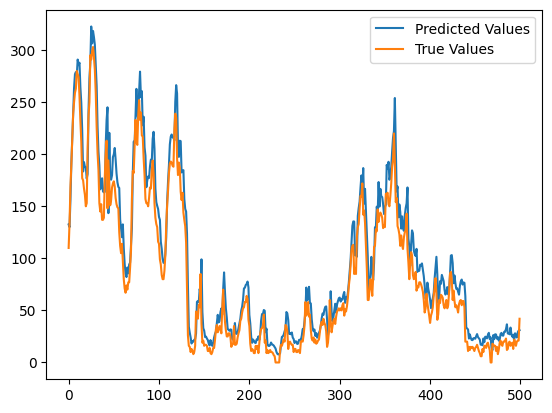

In [126]:
plt.plot(test_results['Model Predictions'][:500], label='Predicted Values')
plt.plot(test_results['Actual'][:500], label='True Values')
plt.legend()
plt.show()

This seems to be best model, takes least time and similar accuracy 

Results seem to get progresively worse

ARIMA would have exponential forgetting 

## Multivariate Multi-Step LSTM

## GPU Performance

Using Apple's Metal API with Keras (TensorFlow)

In [63]:
!pip install tensorflow-macos
!pip install tensorflow-metal

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [65]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))




Num GPUs Available:  1
Num GPUs Available:  1
Device list:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preprocess Data for GPU Usage 
The GPU version of tensorflow works with 32 bit floats which is important because some records might now return NAN on a GPU.

In [88]:
X_train.dtype, y_train.dtype

(array([[[1.2977867e-01, 3.5294119e-01, 2.4590164e-01, ...,
          2.2900112e-03, 0.0000000e+00, 0.0000000e+00],
         [1.4889336e-01, 3.6764705e-01, 2.4590164e-01, ...,
          3.8109887e-03, 0.0000000e+00, 0.0000000e+00],
         [1.5995976e-01, 4.2647058e-01, 2.2950819e-01, ...,
          5.3319661e-03, 0.0000000e+00, 0.0000000e+00],
         ...,
         [1.3279678e-01, 4.8529410e-01, 2.2950819e-01, ...,
          2.3669144e-02, 0.0000000e+00, 0.0000000e+00],
         [1.4084508e-01, 4.8529410e-01, 2.2950819e-01, ...,
          2.9018201e-02, 3.7037037e-02, 0.0000000e+00],
         [1.5291750e-01, 4.7058824e-01, 2.2950819e-01, ...,
          3.4367256e-02, 0.0000000e+00, 0.0000000e+00]],
 
        [[1.4889336e-01, 3.6764705e-01, 2.4590164e-01, ...,
          3.8109887e-03, 0.0000000e+00, 0.0000000e+00],
         [1.5995976e-01, 4.2647058e-01, 2.2950819e-01, ...,
          5.3319661e-03, 0.0000000e+00, 0.0000000e+00],
         [1.8209256e-01, 4.8529410e-01, 2.2950819e-01, 

In [ ]:
import numpy as np

def preprocess_sequences(X, y):
    """
    Preprocess sequence arrays to ensure compatibility with GPU training.
    - Converts to float32.
    - Handles NAN and infinite values.
    - Caps extreme values to a reasonable range.
    
    Args:
        X (np.array): Input sequences (3D array for LSTM).
        y (np.array): Target values (1D or 2D array).
        
    Returns:
        X_preprocessed, y_preprocessed (np.array, np.array): Preprocessed arrays.
    """
    #Convert to float32 for GPU compatibility
    X = X.astype(np.float32)
    y = y.astype(np.float32)

    #Handle NAN and infinite values
    X = np.nan_to_num(X, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
    y = np.nan_to_num(y, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

    # Cap extreme values to prevent instability
    X = np.clip(X, -10, 10)  # Example range, adjust based on your data distribution
    y = np.clip(y, -10, 10)

    return X, y


X_train, y_train  =  preprocess_sequences(X_train, y_train)
X_test,y_test = preprocess_sequences(X_test, y_test)

In [76]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]
MV_LSTM = Sequential()
MV_LSTM.add(Input(shape =(n_steps, n_features)))
MV_LSTM.add(LSTM(32,return_sequences=True))
MV_LSTM.add(Dropout(0.2)) #Prevent overfitting
MV_LSTM.add(LSTM(16, return_sequences=False))
MV_LSTM.add(Dense(n_outputs, activation='tanh')) #Dense output layer with 1 unit (regression problem)

#Compile the model
metrics="RootMeanSquaredError()"
optimzer="adam"
loss = 'mse'

MV_LSTM.compile(optimizer=Adam(learning_rate = 0.001), loss=loss, metrics = [RootMeanSquaredError()])


MV_LSTM.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 12, 32)         │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401 (32.82 KB)

 Trainable params: 8,401 (32.82 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
with tf.device('/CPU:0'):
    test4 = MV_LSTM.fit(X_train, y_train, epochs=17, validation_split=0.1, batch_size=64,shuffle=False)

Epoch 1/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0051 - root_mean_squared_error: 0.0710 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 2/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0024 - root_mean_squared_error: 0.0484 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 3/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 9.7060e-04 - val_root_mean_squared_error: 0.0312
Epoch 4/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 6.2639e-04 - val_root_mean_squared_error: 0.0250
Epoch 5/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 5.1089e-04 - val_root_mean_squared_error: 0.0226
Epoch 6/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 5.0447e-04 - val_root_mean_squared_error: 0.0225
Epoch 7/150
612/612 ━━━━━━━━

Now evaluate on test 

In [78]:
with tf.device('/GPU:0'):
    test4 = MV_LSTM.fit(X_train, y_train, epochs=17, validation_split=0.1, batch_size=64,shuffle=False)

Epoch 1/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 7.1565e-04 - root_mean_squared_error: 0.0267 - val_loss: 5.5957e-04 - val_root_mean_squared_error: 0.0237
Epoch 2/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 7.0150e-04 - root_mean_squared_error: 0.0264 - val_loss: 5.4820e-04 - val_root_mean_squared_error: 0.0234
Epoch 3/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 7.0708e-04 - root_mean_squared_error: 0.0265 - val_loss: 5.4114e-04 - val_root_mean_squared_error: 0.0233
Epoch 4/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 7.0842e-04 - root_mean_squared_error: 0.0265 - val_loss: 5.5124e-04 - val_root_mean_squared_error: 0.0235
Epoch 5/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 7.1348e-04 - root_mean_squared_error: 0.0266 - val_loss: 5.8908e-04 - val_root_mean_squared_error: 0.0243
Epoch 6/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.0340e-04 - root_mean_squared_error: 0.0264 - val_loss: 5.8457e-04 - val_root_mean_squared_erro

KeyboardInterrupt: 

# AUTOENCODERS

Autoencoders for anomaly detection in pollution levels.

- Anomaly detection is critical for identifying abnormalities in time series data
- LSTM autoencoders leverage LSTM networks to encode time series into vector representations and reconstruct inputs
- High reconstruction error signifies anomalies not seen during training
- LSTMs help capture time dependencies well for accurate anomaly evaluation
- Autoencoder training must be optimized carefully to distinguish anomalies effectively

In [88]:
X_train.shape

(43452, 12, 8)

The model needs time to learn the important features so increase epochs and introduce early stopping.

In [37]:
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.models import Sequential


n_steps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]
encoder_decoder = Sequential()
encoder_decoder.add(Input(shape =(n_steps, n_features)))
encoder_decoder.add(LSTM(50, return_sequences=False))
encoder_decoder.add(RepeatVector(n_steps))  # Repeat the bottleneck vector to match the time steps
encoder_decoder.add(LSTM(50, return_sequences=True))
encoder_decoder.add(TimeDistributed(Dense(n_features, activation='linear')))  # Output layer to produce one value per time step

#Compile the model
metrics="RootMeanSquaredError()"
optimzer="adam"
loss = 'mse'

# Autoencoder
encoder_decoder.compile(optimizer=Adam(learning_rate = 0.001), loss=loss, metrics = [RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)




encoder_decoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 12, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 12, 8)          │           408 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,408 (126.59 KB)

 Trainable params: 32,408 (126.59 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
with tf.device('/CPU:0'):
    test4 = encoder_decoder.fit(X_train, X_train, epochs= 150,callbacks=[early_stopping],  validation_split=0.1, batch_size=64,shuffle=False)

Epoch 1/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0233 - root_mean_squared_error: 0.1486 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1272
Epoch 2/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0113 - root_mean_squared_error: 0.1059 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 3/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0094 - root_mean_squared_error: 0.0969 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029
Epoch 4/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 5/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953
Epoch 6/150
612/612 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 7/150
612/612 ━━━━━━━━━━━━━━━━━━━

In [39]:
X_train.shape, y_train.shape

((43452, 12, 8), (43452, 1))

You should be aware that the better the autoencoder is able to reconstruct the input the better it internally encodes the input, in other words if we have a good autoencoder we probably will have an equally good encoder.

Let's take a look at the layers of the encoder_decoder model:


Assess how well the reconstructed dataset matches the original.

In [42]:
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

## Extract reduced feature encoder

In [43]:

rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[1].output)
bottleneck_features = rpt_vector_layer.predict(X_train)
print("Shape of Reduced Features:", bottleneck_features.shape)
print("Sample Reduced Feature Vector:", bottleneck_features[0])

/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_22']. Received: the structure of inputs=*
  warnings.warn(


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Shape of Reduced Features: (43452, 12, 50)
Sample Reduced Feature Vector: [[-0.340924   -0.00336055 -0.03830194 -0.14871076 -0.02434931  0.02754746
  -0.0034116  -0.26713535 -0.3227343   0.04537307  0.0391059   0.00834395
  -0.03194964  0.06336298  0.01539541  0.11949487 -0.26491892  0.09776741
  -0.07389797 -0.00266432 -0.00736532 -0.0875183  -0.05794762 -0.04488153
   0.06621736 -0.3605616  -0.02312522  0.5151794  -0.01300688  0.3202132
  -0.04286701  0.01268022  0.0180891   0.01219168  0.03214499  0.08128574
   0.07719193  0.11458668  0.04975875 -0.0420186  -0.10452947 -0.4622988
  -0.35491905 -0.07809107 -0.08187971 -0.35508895 -0.14061408  0.09652963
   0.02427463 -0.33088505]
 [-0.340924   -0.00336055 -0.03830194 -0.14871076 -0.02434931  0.02754746
  -0.0034116  -0.26713535 -0.3227343   0.04537307  0.0391059   0.00834395
  -0.03194964  0.06336298  0.01539541  0.11949487 -0.26491892  0.09776741
  -0.07389797 -0.00266432 -0.00736532 -0.087

Train a new model MLP or LSTM using bottleneck_features
- try clustering 

In [44]:

time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
encoder_decoder.layers

[<LSTM name=lstm_4, built=True>,
 <RepeatVector name=repeat_vector_2, built=True>,
 <LSTM name=lstm_5, built=True>,
 <TimeDistributed name=time_distributed_2, built=True>]

In [45]:
rpt_vector_layer_output = rpt_vector_layer.predict(X_train[:1])
print('Repeat vector output shape', rpt_vector_layer_output.shape)
print('Repeat vector output sample')
print(rpt_vector_layer_output[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
Repeat vector output shape (1, 12, 50)
Repeat vector output sample
[[-0.34092402 -0.0033605  -0.03830186 -0.14871076 -0.02434931  0.02754746
  -0.00341167 -0.26713526 -0.32273424  0.04537304  0.0391059   0.00834391
  -0.03194964  0.0633629   0.01539536  0.11949487 -0.26491898  0.09776745
  -0.07389794 -0.00266426 -0.00736534 -0.0875183  -0.05794763 -0.04488148
   0.0662174  -0.36056167 -0.02312529  0.5151794  -0.01300671  0.32021314
  -0.04286701  0.0126804   0.01808918  0.01219172  0.03214503  0.08128577
   0.07719186  0.11458668  0.04975865 -0.0420186  -0.10452946 -0.46229884
  -0.35491914 -0.07809104 -0.08187971 -0.35508898 -0.14061409  0.09652964
   0.02427461 -0.33088508]
 [-0.34092402 -0.0033605  -0.03830186 -0.14871076 -0.02434931  0.02754746
  -0.00341167 -0.26713526 -0.32273424  0.04537304  0.0391059   0.00834391
  -0.03194964  0.0633629   0.01539536  0.11949487 -0.26491898  0.09776745
  -0.07389794 -0.00266426 -0.00736534 -0.0875183  -0.

In [46]:
from keras.utils import plot_model

plot_model(encoder_decoder, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')
# demonstrate recreation
yhat = encoder_decoder.predict(X_train, verbose=0)
print(yhat[0,:,0])

[0.12817925 0.1310645  0.13793959 0.13653094 0.13016084 0.11606238
 0.10185628 0.09883869 0.10284048 0.11283571 0.12243301 0.12856635]


Plot the original sequence and reconstructed sequence to see how well the model is performing visually

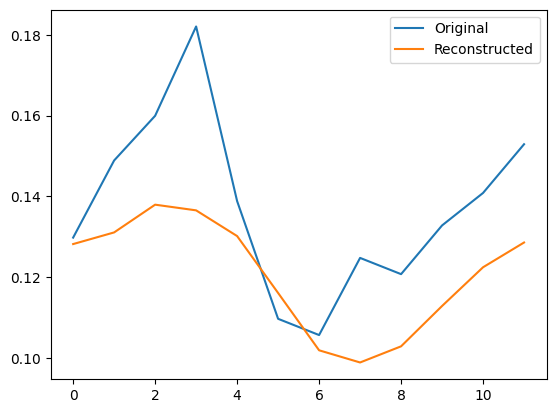

In [47]:

plt.plot(X_train[0, :, 0], label='Original')
plt.plot(yhat[0, :, 0], label='Reconstructed')
plt.legend()
plt.show()

The reconstructed sequence follows the general trend of the original sequence but does not perfectly match the exact values. For example, the reconstructed values seem to lag slightly behind the original at certain points and do not capture sharp peaks.

In [48]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Reshape bottleneck features for LSTM input
bottleneck_features_reshaped = bottleneck_features.reshape(bottleneck_features.shape[0], n_steps, -1)

# LSTM for regression
lstm = Sequential()
lstm.add(LSTM(64, activation='tanh', input_shape=(n_steps, bottleneck_features_reshaped.shape[2])))
lstm.add(Dense(1, activation='linear'))

lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[RootMeanSquaredError()])
lstm.fit(bottleneck_features_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.1)


/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0023 - root_mean_squared_error: 0.0458 - val_loss: 8.2536e-04 - val_root_mean_squared_error: 0.0287
Epoch 2/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339 - val_loss: 7.0709e-04 - val_root_mean_squared_error: 0.0266
Epoch 3/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 7.6605e-04 - val_root_mean_squared_error: 0.0277
Epoch 4/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 8.1824e-04 - val_root_mean_squared_error: 0.0286
Epoch 5/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 7.2101e-04 - val_root_mean_squared_error: 0.0269
Epoch 6/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 8.8664e-04 - val_root_mean_squared_error: 0.0298
Epoch 7/50

In [49]:
test_predictions = lstm.predict(X_test).flatten()
actual_predictions = y_test.flatten()
test_predictions.shape, actual_predictions.shape

test_results = pd.DataFrame(data={
        'Model Predictions': test_predictions,
        'Actual':actual_predictions})
test_results.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


,Model Predictions,Actual
0,1.007365,0.132797
1,0.906132,0.133803
2,1.027235,0.142857
3,1.039873,0.163984
4,1.035616,0.167002


In [50]:
test_predictions = lstm.predict(X_test)

X_test_rescaled=X_test[:, -1, :].copy()

# Invert scaling for the forecast
inv_test_predictions = concatenate((test_predictions, X_test_rescaled[:, 1:]), axis=1)
inv_test_predictions = scaler.inverse_transform(inv_test_predictions)
inv_test_predictions = inv_test_predictions[:, 0]  # Extract the pollution column

y_test = y_test.reshape((len(y_test),1))
inv_actual_predictions = concatenate((y_test, X_test_rescaled[:, 1:]), axis=1)
inv_actual_predictions = scaler.inverse_transform(inv_actual_predictions)
inv_actual_predictions = inv_actual_predictions[:,0]


test_results = pd.DataFrame(data={
        'Model Predictions': inv_test_predictions,
        'Actual':inv_actual_predictions})
  

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_actual_predictions, inv_test_predictions))
print('Test RMSE: %.3f' % rmse)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test RMSE: 812.895


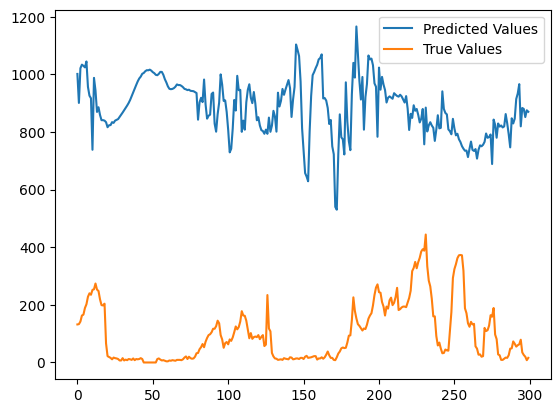

In [51]:
plt.plot(test_results['Model Predictions'][:300], label='Predicted Values')
plt.plot(test_results['Actual'][:300], label='True Values')
plt.legend()
plt.show()

In [ ]:

# Calculate reconstruction errors for each sample
reconstruction_errors = np.mean(np.square(X_train - yhat), axis=(1, 2))

# Average reconstruction error across all samples
mean_reconstruction_error = np.mean(reconstruction_errors)
print("Mean Reconstruction Error:", mean_reconstruction_error)


plt.hist(reconstruction_errors, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Errors")
plt.show()

In [ ]:
from keras.utils import plot_model

plot_model(encoder_decoder, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')
# demonstrate recreation
yhat = encoder_decoder.predict(X_train, verbose=0)
print(yhat[0,:,0])

[0.13243482 0.13483289 0.13909769 0.14202374 0.14107472 0.1346105
 0.12371591 0.11455051 0.11061565 0.10822196 0.10639656 0.10655204]


## Create an Encoder

In [109]:
encoder_input = encoder_decoder.input
encoder_output = encoder_decoder.layers[1].output  #The output of the encoder LSTM layer
encoder_model = Model(inputs=encoder_input, outputs=encoder_output)


/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_145']. Received: the structure of inputs=*
  warnings.warn(


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
[[ 0.02477075 -0.14855123  0.04066667  0.31723383  0.01424882  0.1406128
   0.23440184  0.07330938 -0.04356735  0.00339562 -0.01546647 -0.05253506
   0.03424504 -0.05253672 -0.0235427  -0.03868997 -0.00424934 -0.09577399
   0.01113609 -0.45186275 -0.05720314 -0.02597363 -0.00460299  0.08491086
  -0.46075177  0.00499575  0.18865551 -0.08488303 -0.03617538 -0.00785539
   0.3292493  -0.07771883]
 [ 0.02477075 -0.14855123  0.04066667  0.31723383  0.01424882  0.1406128
   0.23440184  0.07330938 -0.04356735  0.00339562 -0.01546647 -0.05253506
   0.03424504 -0.05253672 -0.0235427  -0.03868997 -0.00424934 -0.09577399
   0.01113609 -0.45186275 -0.05720314 -0.02597363 -0.00460299  0.08491086
  -0.46075177  0.00499575  0.18865551 -0.08488303 -0.03617538 -0.00785539
   0.3292493  -0.07771883]
 [ 0.02477075 -0.14855123  0.04066667  0.31723383  0.01424882  0.1406128
   0.23440184  0.07330938 -0.04356735  0.00339562 -0.01546647 -0.05253506
   0.03424504 -0.0

In [ ]:
#Get Bottleneck Features (Compressed Representation)
bottleneck_features = encoder_model.predict(X_train)
print('Bottleneck Features Shape:', bottleneck_features.shape)
print('Bottleneck Feature Sample:', bottleneck_features[0])

In [ ]:
# Plot Model Diagram
plot_model(encoder_decoder, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')


In [ ]:
# Demonstrate Reconstruction
yhat = encoder_decoder.predict(X_train, verbose=0)


In [ ]:
# Plot Original vs Reconstructed Data
plt.plot(X_train[0, :, 0], label='Original')
plt.plot(yhat[0, :, 0], label='Reconstructed')
plt.legend()
plt.title('Original vs Reconstructed Sequence')
plt.show()

# Calculate Reconstruction Errors
reconstruction_errors = np.mean(np.square(X_train - yhat), axis=(1, 2))
print("Reconstruction Errors:", reconstruction_errors)

## PredictionLSTM Autoencoder 

## Modify the decoder to predict future time steps instead of reconstructing the input.

In [113]:
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.models import Sequential


n_steps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]
encoder_decoder = Sequential()
encoder_decoder.add(Input(shape =(n_steps, n_features)))
encoder_decoder.add(LSTM(32,activation='tanh', return_sequences=False))
encoder_decoder.add(RepeatVector(n_steps))  # Repeat the bottleneck vector to match the time steps
encoder_decoder.add(LSTM(32,activation='tanh', return_sequences=True))
encoder_decoder.add(TimeDistributed(Dense(n_features)))  # Output layer to produce one value per time step

#Compile the model
metrics="RootMeanSquaredError()"
optimzer="adam"
loss = 'mse'

# Autoencoder
encoder_decoder.compile(optimizer=Adam(learning_rate = 0.001), loss=loss, metrics = [RootMeanSquaredError()])




encoder_decoder.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 32)             │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_8 (RepeatVector)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 12, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 12, 8)          │           264 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,832 (54.03 KB)

 Trainable params: 13,832 (54.03 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
with tf.device('/CPU:0'):
    test4 = encoder_decoder.fit(X_train, y_train , epochs=17, validation_split=0.1, batch_size=64,shuffle=False)

Epoch 1/150


2024-11-15 12:34:21.714878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [32,1] vs. [32,12,8]
	 [[{{function_node __inference_one_step_on_data_3858362}}{{node compile_loss/mse/sub}}]]
2024-11-15 12:34:21.714909: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7325450256562127004
2024-11-15 12:34:21.714914: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3859884205947445022
2024-11-15 12:34:21.714919: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12805730785216710672
2024-11-15 12:34:21.714923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [32,1] vs. [32,12,8]
	 [[{{function_node __inference_one_step_on_data_3858362}}{{node compile_loss/mse/sub}}]]
	 [[St

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/mse/sub defined at (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 725, in start

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 215, in start

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 502, in process_one

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code

  File "/var/folders/5b/5l6jp2zn0sn5pggqy7bzs4b00000gn/T/ipykernel_33697/3581227147.py", line 2, in <module>

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/trainer.py", line 398, in _compute_loss

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/trainer.py", line 366, in compute_loss

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/compile_utils.py", line 618, in __call__

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/compile_utils.py", line 659, in call

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/losses/loss.py", line 60, in __call__

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/losses/losses.py", line 27, in call

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/losses/losses.py", line 1303, in mean_squared_error

Detected at node compile_loss/mse/sub defined at (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 725, in start

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 215, in start

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 502, in process_one

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code

  File "/var/folders/5b/5l6jp2zn0sn5pggqy7bzs4b00000gn/T/ipykernel_33697/3581227147.py", line 2, in <module>

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/trainer.py", line 398, in _compute_loss

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/trainer.py", line 366, in compute_loss

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/compile_utils.py", line 618, in __call__

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/compile_utils.py", line 659, in call

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/losses/loss.py", line 60, in __call__

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/losses/losses.py", line 27, in call

  File "/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/losses/losses.py", line 1303, in mean_squared_error

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Incompatible shapes: [32,1] vs. [32,12,8]
	 [[{{node compile_loss/mse/sub}}]]
	 [[StatefulPartitionedCall/adam/truediv_1/_180]]
  (1) INVALID_ARGUMENT:  Incompatible shapes: [32,1] vs. [32,12,8]
	 [[{{node compile_loss/mse/sub}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_3858427]

## MLP with LSTM encoded feature

In [117]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[1].output)

In [ ]:
train['encoded'] = train_encoded
train['label'] = Y_train

valid['encoded'] = validation_encoded
valid['label'] = Y_valid

train.head(10)

# PYSPARKING AN LSTM